# Pulse Function Tests - Envelope System

This notebook tests the pulse envelope system that supports both cosine² and Gaussian envelopes:
- `envelope_type` parameter in `Pulse` class: 'cos2' or 'gaussian'
- `pulse_peak_time` = time where envelope is maximal
- `pulse_FWHM` = Full Width at Half Maximum parameter
- Pulse exists only in `[t_peak - FWHM, t_peak + FWHM]`
- Easy switching between envelope types via `SystemParameters.envelope_type`

Test scenarios:
- Envelope type comparison
- System-wide envelope control
- Fourier Transform spectral comparison

In [11]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt

# Import from our project
from src.visualization.mpl_tex_settings import *
from src.core.pulse_sequences import PulseSequence, Pulse # , identify_pulse_regions
from src.core.pulse_functions import identify_non_zero_pulse_regions
from src.core.pulse_functions import (
    pulse_envelope, E_pulse, Epsilon_pulse,
)
from src.core.system_parameters import SystemParameters
from src.visualization.plotting import (
    Plot_pulse_envelope,
    Plot_E_pulse,
    Plot_Epsilon_pulse,
    Plot_all_pulse_components
)

# Set matplotlib parameters for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Test 1: Envelope System - Easy Switching Between Types

Demonstrate how to easily switch between cosine² and Gaussian envelopes using the new system.

ENVELOPE SYSTEM COMPARISON: COS² vs GAUSSIAN
System envelope types:
  Cos2: cos2
  Gaussian: gaussian


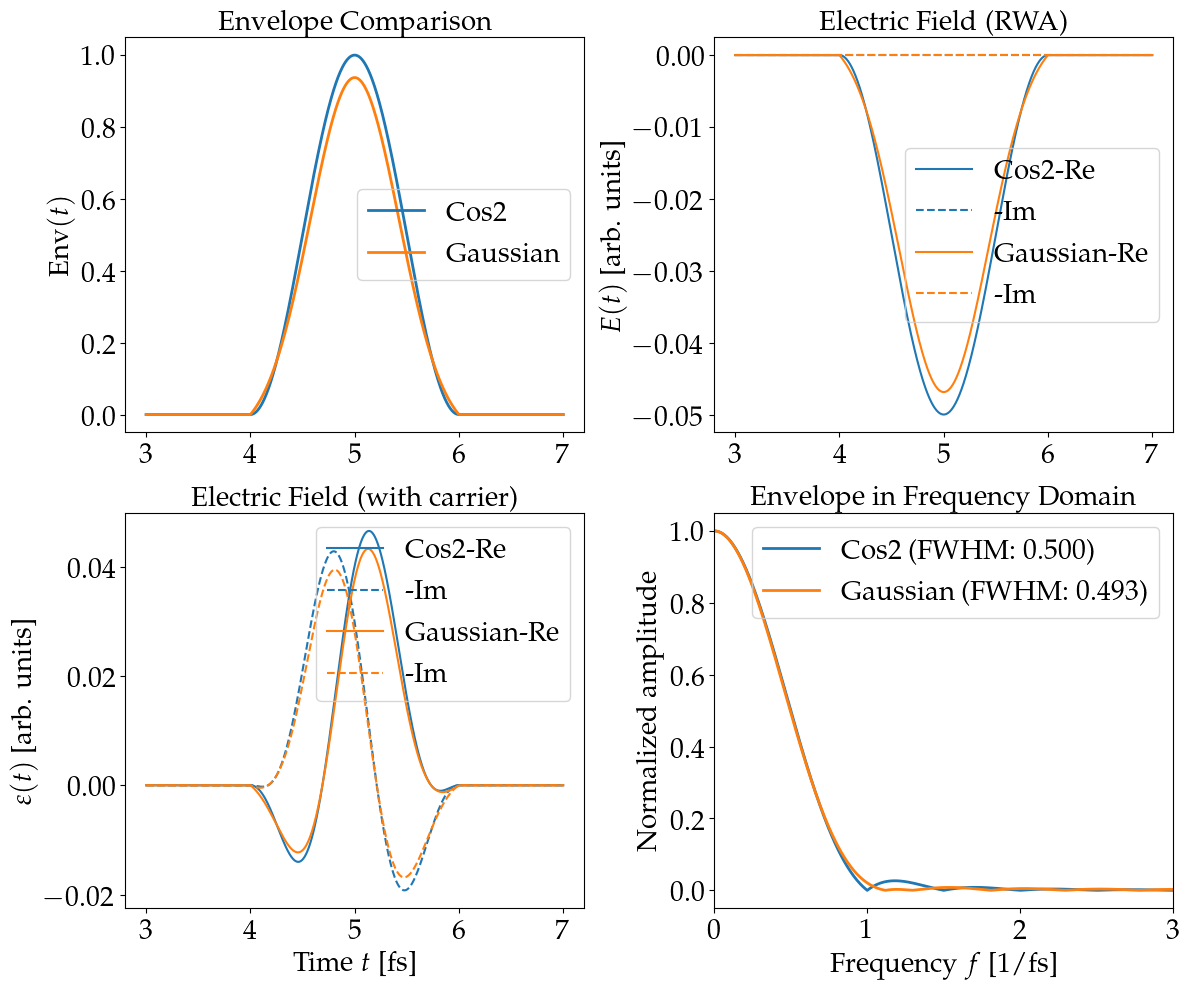


SYSTEM USAGE:
1. Global: SystemParameters(envelope_type='cos2' or 'gaussian')
2. Individual: Pulse(..., envelope_type='...')
3. Functions: pulse_envelope(), E_pulse(), Epsilon_pulse()
✓ Benefit: Easy switching between envelope types


In [17]:
# =============================
# ENVELOPE SYSTEM DEMONSTRATION
# =============================
print("ENVELOPE SYSTEM COMPARISON: COS² vs GAUSSIAN")

# Setup parameters
t_peak = 5.0
FWHM = 1.0

# Create both system types
systems = {
    'cos2': SystemParameters(pulse_FWHM=FWHM, envelope_type='cos2'),
    'gaussian': SystemParameters(pulse_FWHM=FWHM, envelope_type='gaussian')
}

# Create pulse sequences
pulse_params = (t_peak, np.pi)  # (time, phase)
pulse_seqs = {k: PulseSequence.from_args(sys, pulse_params) for k, sys in systems.items()}

print(f"System envelope types:")
for name, seq in pulse_seqs.items():
    print(f"  {name.capitalize()}: {seq.pulses[0].envelope_type}")

# =============================
# TIME & FREQUENCY DOMAIN ANALYSIS
# =============================

# Time domain - for visualization
times = np.linspace(t_peak-2*FWHM, t_peak+2*FWHM, 1000)

# Frequency domain - for spectral analysis
dt = 0.1  # fs (time resolution)
t_spectral = np.arange(0, 300, dt)  # Extended range for frequency resolution
N = len(t_spectral)

# Calculate envelopes for both domains
envelopes = {}
spectra = {}

for name, seq in pulse_seqs.items():
    # Time domain
    envelopes[name] = {
        'envelope': [pulse_envelope(t, seq) for t in times],
        'E_field': [E_pulse(t, seq) for t in times],
        'full_field': [Epsilon_pulse(t, seq) for t in times]
    }
    
    # Frequency domain
    spectral_env = np.array([pulse_envelope(t, seq) for t in t_spectral])
    fft = np.fft.fft(spectral_env)
    freq = np.fft.fftfreq(N, dt)
    
    # Process spectrum data
    pos_idx = freq >= 0
    spectrum = np.abs(fft[pos_idx])
    spectrum /= np.max(spectrum)
    
    # Find spectral width
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    fwhm = freq[pos_idx][above_half[-1]] - freq[pos_idx][above_half[0]] if len(above_half) > 0 else 0
    
    spectra[name] = {
        'freq': freq[pos_idx],
        'amplitude': spectrum,
        'fwhm': fwhm
    }

# =============================
# VISUALIZATION
# =============================

# Set up figure with 4 subplots in 2x2 layout (more compact)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Colors and styles
colors = {'cos2': 'C0', 'gaussian': 'C1'}
linestyles = {'real': '-', 'imag': '--'}

# 1. Envelope comparison
ax = axes[0, 0]
for name, color in colors.items():
    ax.plot(times, envelopes[name]['envelope'], label=f'{name.capitalize()}', 
           color=color, linewidth=2)
ax.set_ylabel(r'Env$(t)$')
ax.set_title('Envelope Comparison')
ax.legend()

# 2. Electric field (RWA)
ax = axes[0, 1]
for name, color in colors.items():
    field = envelopes[name]['E_field']
    ax.plot(times, np.real(field), label=f'{name.capitalize()}-Re', color=color, linestyle='-')
    ax.plot(times, np.imag(field), label=f'-Im', color=color, linestyle='--')
ax.set_ylabel(r'$E(t)$ [arb. units]')
ax.set_title('Electric Field (RWA)')
ax.legend()

# 3. Full field with carrier
ax = axes[1, 0]
for name, color in colors.items():
    field = envelopes[name]['full_field']
    ax.plot(times, np.real(field), label=f'{name.capitalize()}-Re', color=color, linestyle='-')
    ax.plot(times, np.imag(field), label=f'-Im', color=color, linestyle='--')
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$\varepsilon(t)$ [arb. units]')
ax.set_title('Electric Field (with carrier)')
ax.legend()

# 4. Frequency domain
ax = axes[1, 1]
for name, color in colors.items():
    ax.plot(spectra[name]['freq'], spectra[name]['amplitude'], 
           label=f'{name.capitalize()} (FWHM: {spectra[name]["fwhm"]:.3f})',
           color=color, linewidth=2)
ax.set_xlim(0, 3)  # Limit to relevant frequency range
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized amplitude')
ax.set_title('Envelope in Frequency Domain')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nSYSTEM USAGE:")
print("1. Global: SystemParameters(envelope_type='cos2' or 'gaussian')")
print("2. Individual: Pulse(..., envelope_type='...')")
print("3. Functions: pulse_envelope(), E_pulse(), Epsilon_pulse()")
print("✓ Benefit: Easy switching between envelope types")

# Test 2: Pulse regions

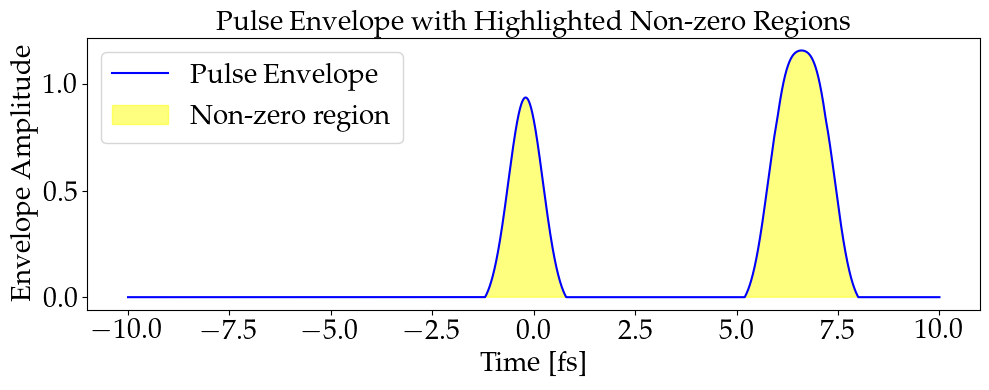

In [13]:
# =============================
# TEST: identify_non_zero_pulse_regions
# =============================

# Define a test time array and a pulse sequence
test_times = np.linspace(-10, 10, 10000)
test_system = SystemParameters(pulse_FWHM=1.0, envelope_type='gaussian')
test_pulse_seq = PulseSequence.from_args(test_system, curr=(7.0, 0.0), prev=(6.2, 0.0), preprev=(-0.2, 0.0))

# Get active regions where pulse envelope is non-zero
active_regions = identify_non_zero_pulse_regions(test_times, test_pulse_seq)
active_times = test_times[active_regions]  # Only times where pulses are active

# Calculate the envelope across all times (now works with array input)
envelope_values = pulse_envelope(test_times, test_pulse_seq)

# Plot the envelope and highlight active regions
plt.figure(figsize=(10, 4))
plt.plot(test_times, envelope_values, 'b-', label='Pulse Envelope')
plt.fill_between(test_times, envelope_values, where=active_regions, 
                 color='yellow', alpha=0.5, label='Non-zero region')
plt.xlabel('Time [fs]')
plt.ylabel('Envelope Amplitude')
plt.title('Pulse Envelope with Highlighted Non-zero Regions')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()